In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
from Bio import SeqIO

In [6]:
fasta_seq = SeqIO.parse('../mobidb_validation/generate_fastas/out/allseq.fasta', 'fasta')
fasta_disorder = SeqIO.parse('../mobidb_validation/generate_fastas/out/alldisorder.fasta', 'fasta')

In [7]:
def get_segments(aa_seq, label_seq, segment_type, accession, description):
    #print(label_seq)
    slices = ndimage.find_objects(ndimage.label(label_seq)[0])
    #print(slices)
    ds = []
    for s in slices:
        segment = aa_seq[s[0]]  # Unpack 1-element slice tuple
        d = {'accession': accession, 'description': description, 
             'segment_type': segment_type, 'len': len(segment), 
             'index': (s[0].start, s[0].stop)}
        
        aa_counts = count_amino_acids(segment)
        d.update(aa_counts)
        ds.append(d)
    return ds


def count_amino_acids(aa_seq):
    aa_codes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
                'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 
                'Y', 'V', 'O', 'U', 'B', 'Z', 'X', 'J']
    d = {aa: 0 for aa in aa_codes}
    for aa in aa_seq:
        d[aa] += 1
    return d

In [8]:
protein_seq_dict = {}
for protein in fasta_seq:
    protein_seq_dict[protein.id.split("|")[0]] = str(protein.seq)

In [9]:
rows = []
for protein in fasta_disorder:
    dis_labels = [s == '1' for s in protein.seq]
    ord_labels = [s == '0' for s in protein.seq]

    accession = protein.id.split("|")[0]
    description = protein.description.split("|")[-1]
    aa_seq = protein_seq_dict[accession]
    
    # Disordered regions have the code 'D' and ordered regions have the code 'O'
    # The entire protein is added with the code 'P'
    ds_dis = get_segments(aa_seq, dis_labels, 'D', accession, description)
    ds_ord = get_segments(aa_seq, ord_labels, 'O', accession, description)
    ds_all = get_segments(aa_seq, [True for _ in range(len(aa_seq))], 'P', accession, description)

    # Add ds to rows
    rows.extend(ds_dis)
    rows.extend(ds_ord)
    rows.extend(ds_all)
df1 = pd.DataFrame(rows)
print(df1)

       accession                                        description  \
0         Q9UPN6  SR-related and CTD-associated factor 8 OS=Homo...   
1         Q9UPN6  SR-related and CTD-associated factor 8 OS=Homo...   
2         H0USY8  sequence OS=Ancylostoma ceylanicum OX=53326 GN...   
3         H0USY8  sequence OS=Ancylostoma ceylanicum OX=53326 GN...   
4         P04631  Protein S100-B OS=Rattus norvegicus (Rat) OX=1...   
...          ...                                                ...   
111523    Q9JKS6  Protein piccolo OS=Rattus norvegicus (Rat) OX=...   
111524    P20929     Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB   
111525    P20929     Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB   
111526    P20929     Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB   
111527    P20929     Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB   

       segment_type   len         index    A    R    N    D   C  ...    T   W  \
0                 O  1271     (0, 1271)   62   87   61   63   6  .

In [83]:
df1

,accession,description,segment_type,len,index,A,R,N,D,C,...,T,W,Y,V,O,U,B,Z,X,J
0,Q9UPN6,SR-related and CTD-associated factor 8 OS=Homo...,O,1271,"(0, 1271)",62,87,61,63,6,...,62,11,16,99,0,0,0,0,0,0
1,Q9UPN6,SR-related and CTD-associated factor 8 OS=Homo...,P,1271,"(0, 1271)",62,87,61,63,6,...,62,11,16,99,0,0,0,0,0,0
2,H0USY8,sequence OS=Ancylostoma ceylanicum OX=53326 GN...,O,243,"(0, 243)",16,18,11,16,0,...,10,1,3,10,0,0,0,0,0,0
3,H0USY8,sequence OS=Ancylostoma ceylanicum OX=53326 GN...,P,243,"(0, 243)",16,18,11,16,0,...,10,1,3,10,0,0,0,0,0,0
4,P04631,Protein S100-B OS=Rattus norvegicus (Rat) OX=1...,O,92,"(0, 92)",4,1,2,7,2,...,3,0,1,7,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111523,Q9JKS6,Protein piccolo OS=Rattus norvegicus (Rat) OX=...,P,5085,"(0, 5085)",348,209,80,248,32,...,389,16,111,252,0,0,0,0,0,0
111524,P20929,Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB,D,38,"(6609, 6647)",7,1,1,6,0,...,1,1,2,2,0,0,0,0,0,0
111525,P20929,Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB,O,6609,"(0, 6609)",469,270,302,515,52,...,349,90,407,388,0,0,0,0,0,0
111526,P20929,Nebulin OS=Homo sapiens (Human) OX=9606 GN=NEB,O,22,"(6647, 6669)",2,2,1,0,0,...,3,0,2,2,0,0,0,0,0,0


# Length Distribution of Disordered Regions in Proteins

Text(0.5, 1.0, 'Length of Disordered Regions')

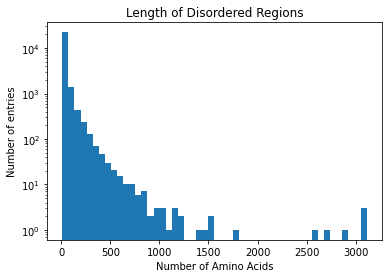

In [120]:
disorder = df1[df1['segment_type'] == 'D']
plt.hist(disorder['len'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Disordered Regions')

## Length of Disordered Regions Upper Limit

Length of the disordered regions drops off significantly after about a length of 90, making the upper limit of the length of our data amino acid sequence be 180, because we want >50% unmasked (amino acid sequences of the ordered regions). 

(array([11812.,  4799.,  2475.,  1344.,   832.,   596.,   438.,   350.,
          291.,   239.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

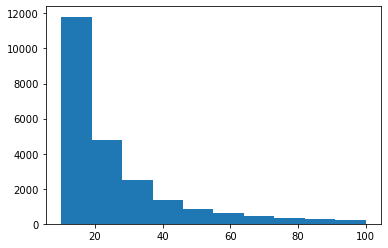

In [121]:
disless100 = disorder[disorder['len'] <= 100]
plt.hist(disless100['len'])

The cut off for a disordered region is more than 30 amino acid residues. And we want the max disordered region length to be 90 amino acids, as stated above. This gives us 5,619 proteins for our dataset

(array([1543., 1079.,  698.,  536.,  438.,  354.,  285.,  259.,  205.,
         222.]),
 array([30., 36., 42., 48., 54., 60., 66., 72., 78., 84., 90.]),
 <BarContainer object of 10 artists>)

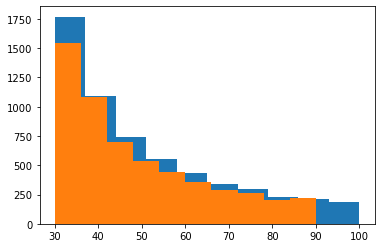

In [125]:
dismore30 = disless100[disless100['len'] >= 30]
plt.hist(dismore30['len'])
disless90 = dismore30[dismore30['len'] <= 90] 
plt.hist(disless90['len'])

In [126]:
disless90

,accession,description,segment_type,len,index,A,R,N,D,C,...,T,W,Y,V,O,U,B,Z,X,J
12,O95405,Zinc finger FYVE domain-containing protein 9 O...,D,89,"(662, 751)",10,8,2,5,9,...,4,1,1,6,0,0,0,0,0,0
13,O95405,Zinc finger FYVE domain-containing protein 9 O...,D,89,"(764, 853)",11,3,6,2,1,...,4,1,1,7,0,0,0,0,0,0
52,P26039,Talin-1 OS=Mus musculus (Mouse) OX=10090 GN=Tln1,D,39,"(133, 172)",0,2,1,5,0,...,4,0,0,0,0,0,0,0,0,0
54,P26039,Talin-1 OS=Mus musculus (Mouse) OX=10090 GN=Tln1,D,82,"(398, 480)",4,2,2,3,0,...,3,0,1,6,0,0,0,0,0,0
58,P26039,Talin-1 OS=Mus musculus (Mouse) OX=10090 GN=Tln1,D,30,"(1909, 1939)",4,1,0,0,2,...,1,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111450,Q62234,Myomesin-1 OS=Mus musculus (Mouse) OX=10090 GN...,D,72,"(1329, 1401)",2,3,2,4,3,...,4,3,2,5,0,0,0,0,0,0
111479,Q00963,Spectrin beta chain OS=Drosophila melanogaster...,D,50,"(2194, 2244)",6,2,3,4,0,...,2,0,2,2,0,0,0,0,0,0
111492,Q8RL76,sequence OS=Pseudomonas fluorescens OX=294 GN=...,D,30,"(2700, 2730)",8,1,0,0,0,...,4,0,0,2,0,0,0,0,0,0
111517,Q9JKS6,Protein piccolo OS=Rattus norvegicus (Rat) OX=...,D,35,"(4681, 4716)",2,3,3,0,0,...,2,1,2,4,0,0,0,0,0,0
